<a href="https://colab.research.google.com/github/roysayan96/Deep_learning/blob/main/autoencoderr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.


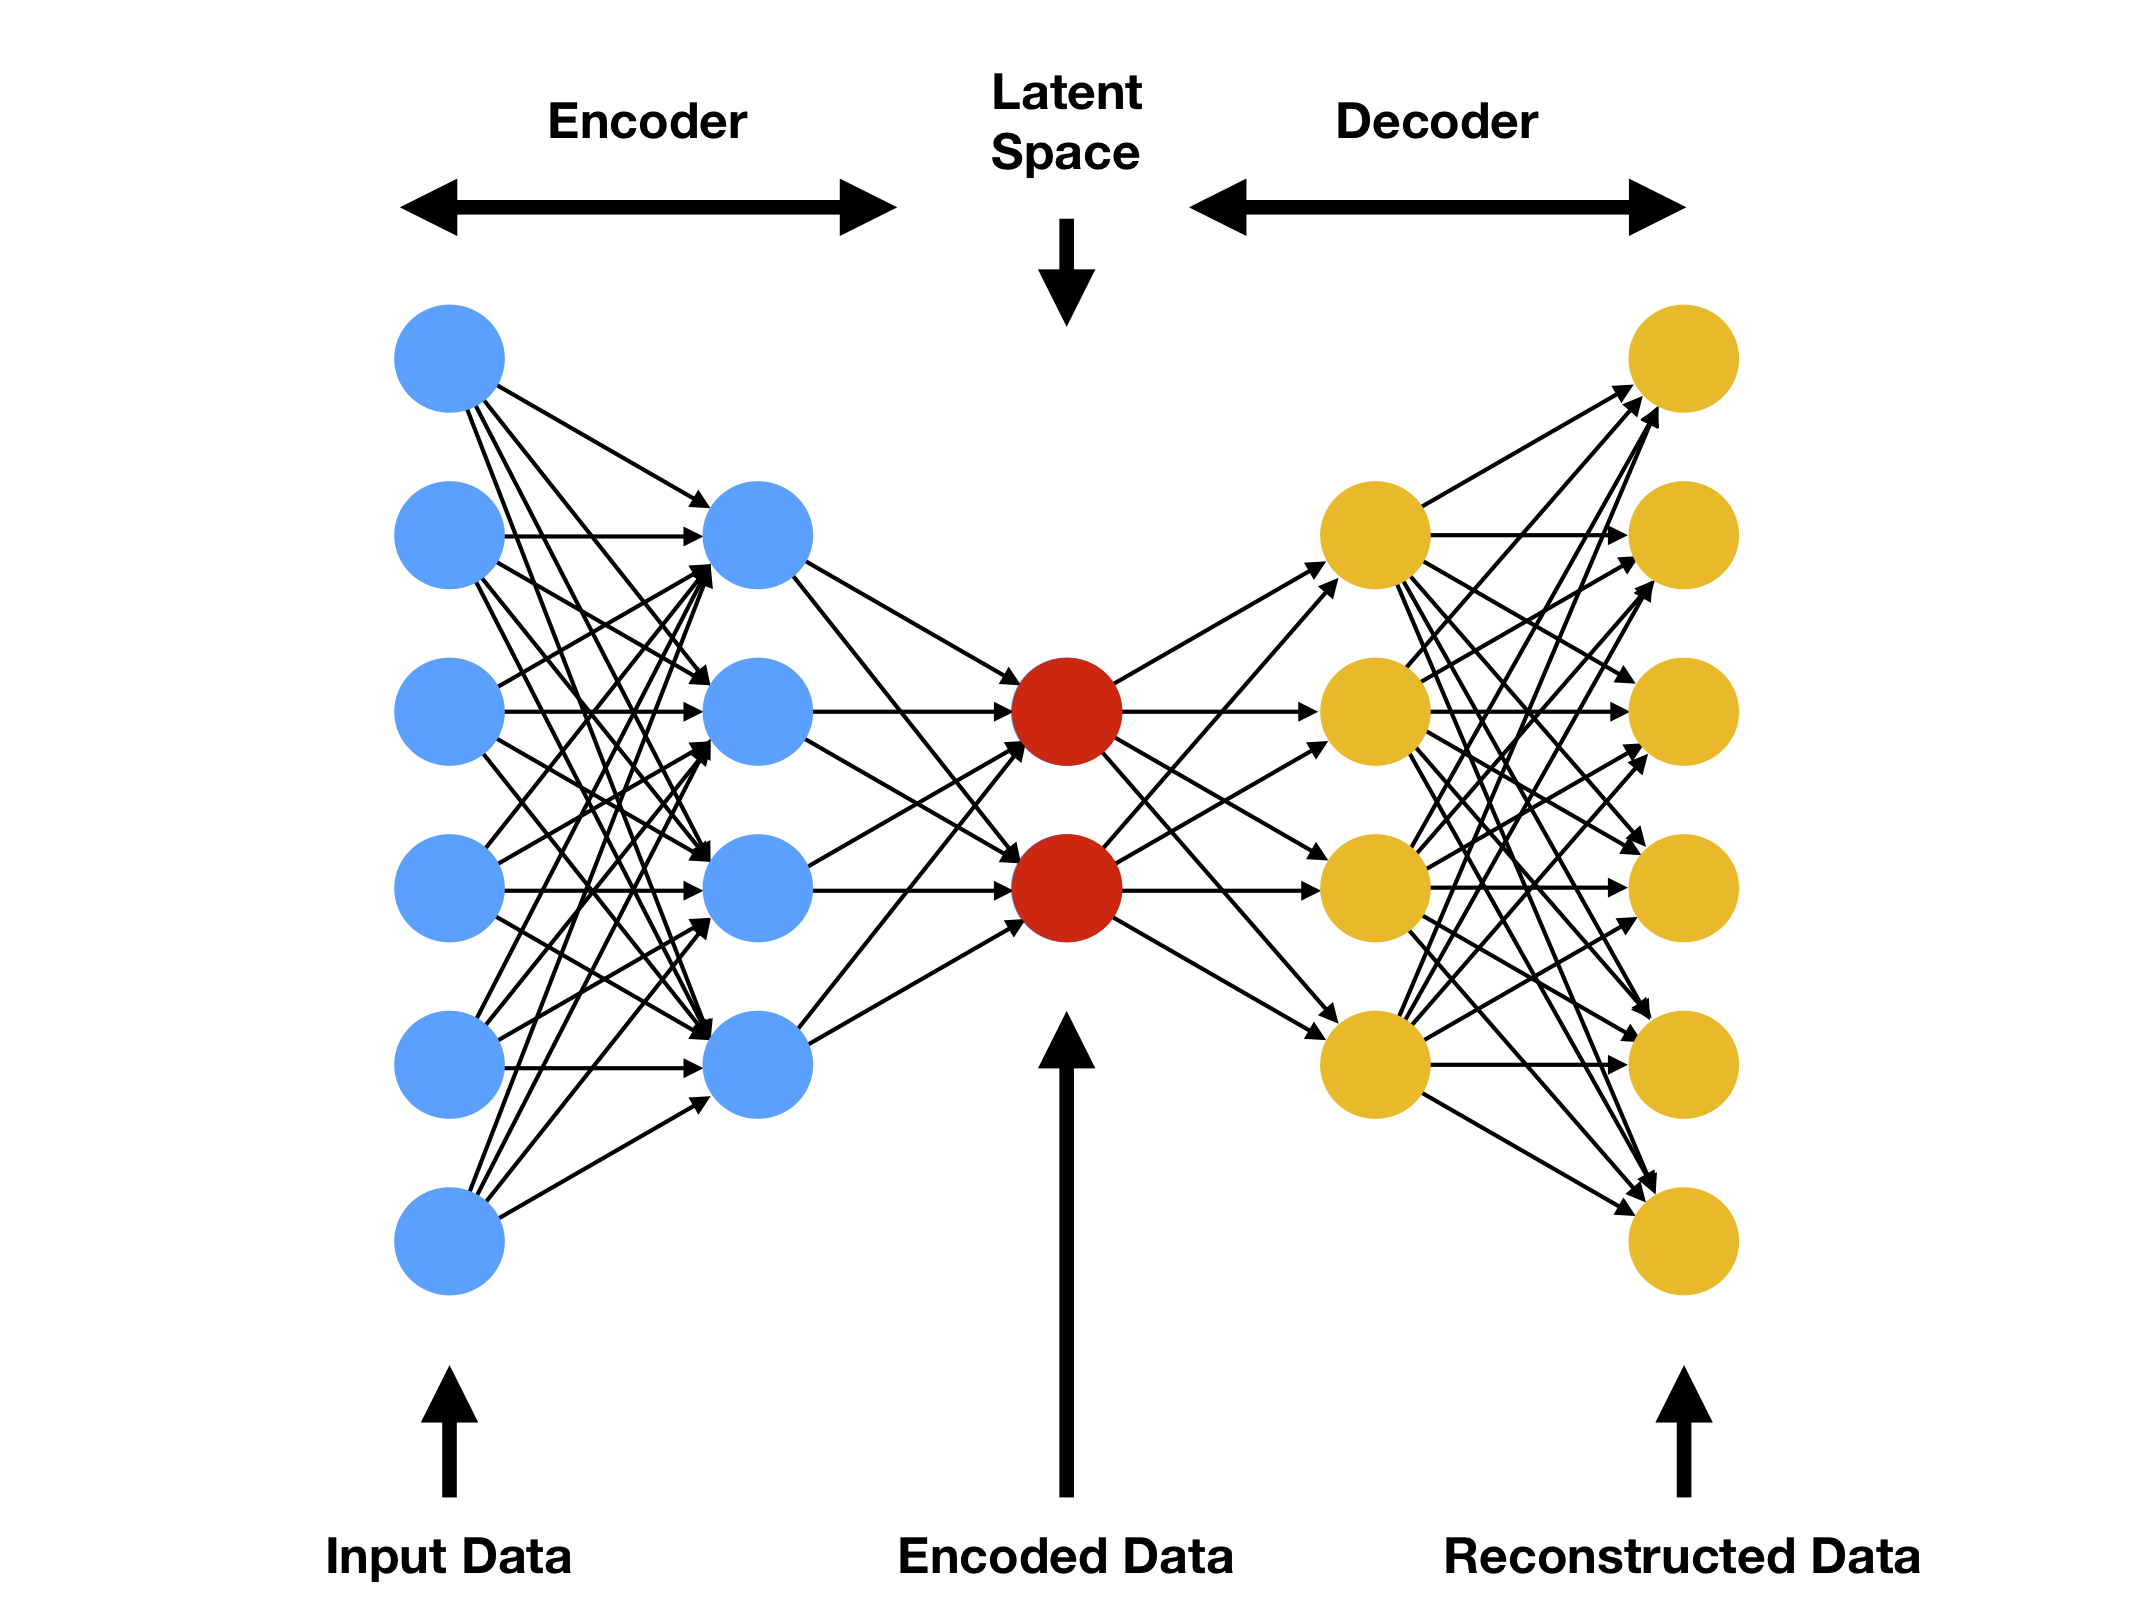

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [3]:
train_data = extract_data('/content/drive/MyDrive/MNISTfolder/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('/content/drive/MyDrive/MNISTfolder/t10k-images-idx3-ubyte.gz', 10000)

In [4]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [5]:
train_labels = extract_labels('/content/drive/MyDrive/MNISTfolder/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('/content/drive/MyDrive/MNISTfolder/t10k-labels-idx1-ubyte.gz',10000)

In [6]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [7]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: H)')

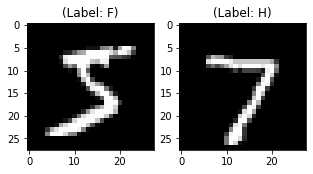

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [9]:
#Data Preprocessing
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [10]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [11]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [12]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [13]:
#verify the maximum value of training and testing data i.e 1 or not..
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [15]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [16]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [17]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584

In [19]:
#train model
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/50
375/375 [==============================] - 41s 29ms/step - loss: 0.1147 - val_loss: 0.1123
Epoch 2/50
375/375 [==============================] - 10s 27ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 3/50
375/375 [==============================] - 10s 27ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 4/50
375/375 [==============================] - 10s 27ms/step - loss: 0.1121 - val_loss: 0.1123
Epoch 5/50
375/375 [==============================] - 10s 27ms/step - loss: 0.1117 - val_loss: 0.1123
Epoch 6/50
375/375 [==============================] - 10s 27ms/step - loss: 0.1118 - val_loss: 0.1123
Epoch 7/50
375/375 [==============================] - 10s 27ms/step - loss: 0.1117 - val_loss: 0.1123
Epoch 8/50
375/375 [==============================] - 10s 27ms/step - loss: 0.1121 - val_loss: 0.1123
Epoch 9/50
375/375 [==============================] - 10s 27ms/step - loss: 0.1123 - val_loss: 0.1123
Epoch 10/50
375/375 [==============================] - 10s 28ms/step - loss: 0.112

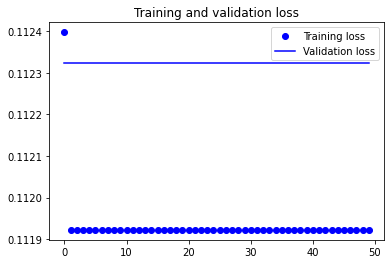

In [20]:
#Training vs Validation Loss Plot
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
#Predicting on Test Data
pred = autoencoder.predict(test_data)
pred.shape

(10000, 28, 28, 1)

Test Images


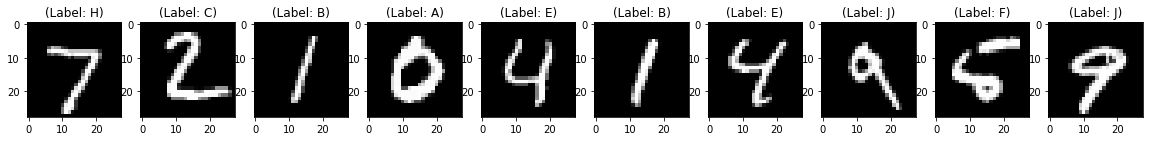

In [22]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
